In [1]:
!pip install gensim scikit-learn

In [2]:
import gensim
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re

In [7]:
!wget -O dataset_product.csv 'https://raw.githubusercontent.com/berUang-Capstone/ML/main/Dataset/Dataset.csv'


--2024-06-10 01:36:34--  https://raw.githubusercontent.com/berUang-Capstone/ML/main/Dataset/Dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167034 (163K) [text/plain]
Saving to: ‘dataset_product.csv’

dataset_product.csv 100%[===================>] 163.12K  --.-KB/s    in 0.02s   

2024-06-10 01:36:34 (7.05 MB/s) - ‘dataset_product.csv’ saved [167034/167034]



In [8]:
# file_path = 'Dataset.csv'
data = pd.read_csv('dataset_product.csv')

In [9]:
data.head()

,Nama Product,Categories,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,Nasi Goreng,Food,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Es Teh,Food,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bakso,Food,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Mie Ayam,Food,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Kopi,Food,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data.columns

Index(['Nama Product', 'Categories', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10'],
      dtype='object')

In [10]:
data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10'], inplace=True)

In [11]:
data.columns

Index(['Nama Product', 'Categories'], dtype='object')

In [12]:
duplicated_rows = data[data.duplicated()]

# Menampilkan duplikasi
print(duplicated_rows)

                 Nama Product Categories
335               Lampu pintu    Belanja
373                   Lasagna       Food
389                    Nastar       Food
390                 Kastengel       Food
394                   Kerupuk       Food
...                       ...        ...
4917        Sate Khas Senayan       Food
4919  Soto Betawi Haji Husein       Food
4930     Ayam Bakar Wong Solo       Food
4945       Pallubasa Serigala       Food
4968  Nasi Goreng Kebon Sirih       Food

[692 rows x 2 columns]


In [13]:
data = data.drop_duplicates()

In [14]:
category_counts = data['Categories'].value_counts()
print(category_counts)

Categories
Belanja         1833
Food            1319
Transportasi    1156
Name: count, dtype: int64


In [42]:
belanja = data[data['Categories'] == "Belanja"].head(1156)
food = data[data['Categories'] == "Food"].head(1156)
trans = data[data['Categories'] == "Transportasi"]

data = pd.concat([belanja, food, trans], ignore_index=True)
data

,Nama Product,Categories
0,Kamera belakang,Belanja
1,Kamera dashboard,Belanja
2,Car cover,Belanja
3,Cover motor,Belanja
4,Sabun mobil,Belanja
...,...,...
3463,Expedia Indonesia,Transportasi
3464,Klook Indonesia,Transportasi
3465,Nusatrip,Transportasi
3466,Skyscanner Indonesia,Transportasi


In [43]:
category_counts = data['Categories'].value_counts()
print(category_counts)

Categories
Belanja         1156
Food            1156
Transportasi    1156
Name: count, dtype: int64


In [44]:
filtered_df = data[data['Nama Product'].str.contains("Promo tiket pesawat Traveloka", case=False, na=False)]
filtered_df

,Nama Product,Categories
2875,Promo tiket pesawat Traveloka,Transportasi


In [45]:
def clean_product_name(product_name):
    return re.sub(r'[()\-,.]', '', product_name)  # Membersihkan data menggunakan regex

# Mengaplikasikan fungsi clean_product_name ke setiap elemen dalam kolom 'Nama Product'
data['Nama Product'] = [clean_product_name(product_name) for product_name in data['Nama Product']]

In [46]:
data['Nama Product'].tail(1000)

2468    Harga tiket Pesawat internasional
2469             Lokasi parkir di Bandara
2470                    Biaya antar Gojek
2471                     Layanan Grab car
2472               Diskon Gocar bulan ini
                      ...                
3463                    Expedia Indonesia
3464                      Klook Indonesia
3465                             Nusatrip
3466                 Skyscanner Indonesia
3467                       Wego Indonesia
Name: Nama Product, Length: 1000, dtype: object

In [47]:
vocab = data['Nama Product']
vocab = [text.lower() for text in vocab]

In [48]:
labels = data['Categories']
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
one_hot_labels = to_categorical(integer_encoded, num_classes=3)
one_hot_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [49]:
vocab_size = 500
max_length = data['Nama Product'].str.split().str.len().max()
embedding_dim = 16
trunc_type='post'
oov_tok = "<OOV>"

In [50]:
tokenizer = Tokenizer(num_words = vocab_size , oov_token=oov_tok)
tokenizer.fit_on_texts(vocab)
word_index  = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(vocab)
padded_sequences = pad_sequences(sequences, padding=trunc_type,maxlen=max_length)

testing_sequences = tokenizer.texts_to_sequences(vocab)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, truncating=trunc_type)

print(word_index)
print(sequences)


{'<OOV>': 1, 'es': 2, 'tiket': 3, 'soto': 4, 'stasiun': 5, 'bandara': 6, 'krim': 7, 'kmp': 8, 'buah': 9, 'pembayaran': 10, 'teh': 11, 'sayur': 12, 'kereta': 13, 'tahu': 14, 'layanan': 15, 'lampu': 16, 'nasi': 17, 'terminal': 18, 'diskon': 19, 'pesawat': 20, 'promo': 21, 'gocar': 22, 'online': 23, 'biaya': 24, 'grab': 25, 'pelabuhan': 26, 'nomor': 27, 'harga': 28, 'gojek': 29, 'maxim': 30, 'saus': 31, 'taxi': 32, 'kacang': 33, 'tarif': 34, 'lontong': 35, 'belanja': 36, 'kue': 37, 'traveloka': 38, 'langganan': 39, 'air': 40, 'bis': 41, 'rute': 42, 'transaksi': 43, 'susu': 44, 'pembelian': 45, 'lemon': 46, 'daun': 47, 'daging': 48, 'jadwal': 49, 'nusantara': 50, 'pengiriman': 51, 'bus': 52, 'kai': 53, 'ayam': 54, 'bayam': 55, 'kode': 56, 'waktu': 57, 'tagihan': 58, 'busway': 59, 'jarak': 60, 'kartu': 61, 'hijau': 62, 'api': 63, 'lrt': 64, 'pelanggan': 65, 'pesanan': 66, 'fasilitas': 67, 'krl': 68, 'mrt': 69, 'parkir': 70, 'hemat': 71, 'bank': 72, 'premium': 73, 'produk': 74, 'pemesanan': 

In [51]:
padded_sequences

array([[241,   1,   0, ...,   0,   0,   0],
       [241, 242,   0, ...,   0,   0,   0],
       [  1, 243,   0, ...,   0,   0,   0],
       ...,
       [  1,   0,   0, ...,   0,   0,   0],
       [  1, 169,   0, ...,   0,   0,   0],
       [  1, 169,   0, ...,   0,   0,   0]], dtype=int32)

In [52]:
train_data, test_data, train_labels, test_labels = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=123 ,shuffle=True , stratify=labels)

In [53]:
model = Sequential([
          tf.keras.layers.Embedding(vocab_size, 32, input_length=max_length),
          tf.keras.layers.GlobalAveragePooling1D(),
          # tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dense(15, activation='relu'),
          tf.keras.layers.Dense(3, activation='softmax')
])

# Use categorical crossentropy because this is a multi-class problem
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

In [54]:
num_epochs = 50

# Train the model
history = model.fit(train_data, train_labels, epochs=num_epochs, validation_data=(test_data, test_labels))

Epoch 1/50
87/87 [==============================] - 1s 5ms/step - loss: 1.0710 - accuracy: 0.5692 - val_loss: 1.0226 - val_accuracy: 0.7810
Epoch 2/50
87/87 [==============================] - 0s 3ms/step - loss: 0.9214 - accuracy: 0.8183 - val_loss: 0.7796 - val_accuracy: 0.8631
Epoch 3/50
87/87 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.8792 - val_loss: 0.4998 - val_accuracy: 0.8948
Epoch 4/50
87/87 [==============================] - 0s 3ms/step - loss: 0.4211 - accuracy: 0.8875 - val_loss: 0.3661 - val_accuracy: 0.9049
Epoch 5/50
87/87 [==============================] - 0s 3ms/step - loss: 0.3231 - accuracy: 0.8926 - val_loss: 0.3038 - val_accuracy: 0.8934
Epoch 6/50
87/87 [==============================] - 0s 3ms/step - loss: 0.2734 - accuracy: 0.8962 - val_loss: 0.2666 - val_accuracy: 0.8948
Epoch 7/50
87/87 [==============================] - 1s 9ms/step - loss: 0.2449 - accuracy: 0.8958 - val_loss: 0.2506 - val_accuracy: 0.9078
Epoch 8/50
87/87 [==

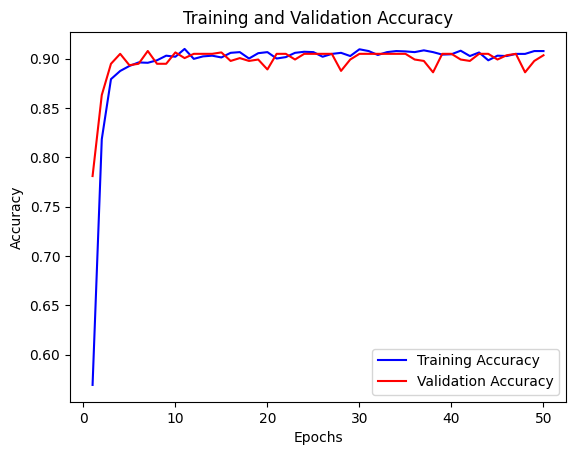

In [55]:
# Mengakses history dari model
history = model.history.history

# Menyimpan akurasi dari data training dan data validasi
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

# Mengakses epoch
epochs = range(1, len(accuracy) + 1)

# Plotting akurasi training dan validation
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [57]:
# Text input
text_input = 'kue jakarta'

# Ubah teks input menjadi sequence angka menggunakan tokenizer
sequence = tokenizer.texts_to_sequences([text_input])

# Tambahkan padding pada sequence
padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')

# Lakukan prediksi menggunakan model
predictions = model.predict(padded_sequence)

# Output prediksi (nilai probabilitas dari lapisan softmax)
# print("Predicted probabilities:", predictions[0])

treshold = 0.3

# Memeriksa apakah probabilitas tertinggi kurang dari treshold
if np.max(predictions) < treshold:
    predicted_class = "other"
else:
    predicted_class_index = np.argmax(predictions, axis=1)
    predicted_class = label_encoder.inverse_transform(predicted_class_index)

# Output prediksi kelas
print("Predicted Class:", predicted_class)

probabilities_rounded = [round(prob, 4) for prob in predictions[0]]
print("Predicted probabilities:", probabilities_rounded)

1/1 [==============================] - 0s 73ms/step
Predicted Class: ['Food']
Predicted probabilities: [1e-04, 0.9875, 0.0125]
